### Isolation Forest

Данный подход не требует нормальности данных (в смысле рабочего состояния системы), т.е. в данных могут быть аномалии. **Из-за своей склонности к изоляции аномалии изолируются ближе к корню дерева.** В то время как нормальные состояния системы находится как можно глубже. При моделировании строится ансамбль деревьев для предлагаемого датасета, тогда аномалии - это те экземпляры, которые имеют короткую среднюю длину пути. Существует два гиперпараметра модели: количество деревьев в лесу и размер подвыборки.

Изолировать - это значит отделить один объект от остальных. Аномалии наиболее предрасположены к изоляции, поскольку их мало и они отличаются от нормальных объектов. В случайном дереве разбиение экземпляров рекурсивно повторяется до тех пор, пока все экземпляры не будут изолированы. Если лес случайных деревьев вместе создает более короткие пути для некоторых конкретных точек, то они, скорее всего, будут аномалиями. 

Нормальный объект требует больших разбиений для того чтобы быть изолированным, в то время как аномальный объект будет отделен на более ранней стадии. **При разбиении рандомно выбирается признак и сплит-значение** между минимальным и максимальным значениями признака.

Поскольку рекурсивное разбиение может быть представлено в деревовидной структуре, то количество разбиений соответсвует длине пути из корня в терминальную вершину. Поскольку каждое разбиение рандомно, то в отдельности деревья сгенерируют различные разбиения. Тогда для каждой вершины посмотрим его высоту в дереве и усредним по рамеру леса. При увеличении количества деревьев средняя высота будет сходиться к конкретному числу.

<img src="./img/iforest_process.png" alt="Drawing" style="width: 400px; height: 600px"/>

На картинках видно, что аномалия довольно быстро отсекается, и чем больше деревьев в ансамбле тем конкретнее длина пути

**Определение Isolation Tree**. Пусть $T$ это произвольная вершина. Тогда $T$ это либо внешняя вершина без детей, либо внутрення с двумя детьми $(T_l, T_r)$ и *тестом*. Тест содержит значения признака $q$ и сплит-значение $p$, и по критерию $q < p$ разделяет данные в $T_l$ и $T_r$ соответственно.

Пусть дана выборка $X = \{x_1, x_2, \ldots, x_n\}$, тогда для построения модели будем рекурсивно разделять выборку по рандомному признаку $q$ и сплит-значению $p$ до тех пор пока:
* не будет достигнут лимит по высоте дерева (как гиперпараметр модели)
* размер выборки не будет равняться единице $|X| = 1$
* все объекты в выборке не будут иметь одинаковые значения

Isolation Tree это бинарное дерево, т.е. каждая вершина имеет не больше двух дочерних вершин. Чтобы обнаружить аномалии нужно отсортировать вершины по длине пути или *anomaly score* в порядке возрастания, тогда вверху списка будут аномальные вершины.

**Длина пути и anomaly score**. Длина пути $h(x)$ это просто количество ребер от корня дерева до вершины $x$.

Поскольку $ITree$ имеет аналогичную структуру, что и $BST$ (двоичное дерево поиска), то средняя длина внешнего пути оценивается как [неудачный поиск в BST](https://book.huihoo.com/data-structures-and-algorithms-with-object-oriented-design-patterns-in-java/html/page308.html), а здесь [более подробно про связь с гармоническими числами](https://www.cs.csustan.edu/~john/classes/previous_semesters/cs3100_datastructures/2000_04_Fall/Examples/Trees/averageSearchInBST.html). Откуда можно получить среднюю глубину внешней вершины
$$\large c(n) = 2H(n-1) - \frac{2(n-1)}{n}$$

Поскольку $c(n)$ это среднее значение, то можно использовать его для нормализации $h(x)$. Таким образом *anomaly score* для объекта $x$ определяется как $$\Large s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}$$

где $E(h(x))$ это средняя длина пути для объекта $x$ на основе всех деревьев

<img src="./img/iforest_score.png" alt="Drawing" style="width: 400px; height: 300px"/>

Из графика видно, чем чем больше $E(h(x))$ относительно $c(n)$ тем ближе *anomaly score* к нулю и тем менее вероятно что объект $x$ является аномалией. И наоборот. Поэтому можно сделать несколько важных выводов:

* если значение близко к единице, то это определенно аномалия
* если объекты имеют значение $< 0.5$, то их можно рассматривать как нормальные

Как ансамбль деревьев, в котором используются изолированные деревья, IForest а) идентифицирует аномалии как точки с более короткой длиной пути и б) имеет несколько деревьев, действующих как «эксперты» для выявления различных аномалий. Поскольку IForest не нужно изолировать все нормальные экземпляры — большую часть обучающей выборки IForest может хорошо работать с частичной моделью, не изолируя все нормальные точки, и строит модели, используя небольшой размер выборки. При этом большой размер выборки снижает способность IForest изолировать аномалии, поскольку обычные экземпляры могут мешать процессу изоляции и, следовательно, уменьшают его способность однозначно изолировать аномалии. 

**Основые проблемы при поиске аномалий**: *swamping* и *masking*. 

*Swamping* относится к ошибочной идентификации нормальных экземпляров как аномалий (оно же ложноположительное обнаружение). Когда нормальные экземпляры находятся слишком близко к аномалиям, количество разделов, необходимых для разделения аномалий, увеличивается, что затрудняет отличить аномалии от нормальных экземпляров. 

*Masking* это наличие слишком большого количества аномалий (групповые аномалии), скрывающих свое присутствие. Когда кластер аномалий большой и плотный, также увеличивается количество разделов для изоляции каждой аномалии. 

В этих обстоятельствах оценки с использованием $Itrees$ имеют большую длину пути, что и затрудняет обнаружение аномалий. Обе проблемы вытекают из слишком большого размера выборки. Способность $IForest$ работать с частичной моделью позволяет избежать этих проблем, и этим нужно пользоваться. Это связано с тем, что: 1) подвыборка контролирует размер данных, что помогает IForest лучше изолировать аномалии и 2) каждое изолированное дерево может быть специализировано, поскольку каждая подвыборка включает различный набор аномалий или даже не содержит аномалий. 

###  Обнаружение аномалий с помощью IForest

Алгоритм состоит из двух стадий, как в классическом машинном обучении. Первая стадия - тренировка, строит $ITrees$ на подвыборках из тренировочных данных. На второй стадии - тестирование, тестовые экземпляры проходят через деревья изоляции, чтобы получить оценку аномалии для каждого экземпляра.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

from utils.metrics import mar, far, f1_score
from utils.data import load_df

$MAR = \frac{FN}{TP + FN}$;  $FAR = \frac{FP}{FP + TN}$;  $F1 = \frac{TP}{TP + 0.5(FP + FN)}$

# Fitting

In [68]:
from sklearn.ensemble import IsolationForest
from ipywidgets import IntProgress
from IPython.display import display

IntProgress(value=0, description='valve1', max=16, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.3529841656516443
FAR = 0.03814024132984558
MAR = 0.7703281027104137)


IntProgress(value=0, description='valve2', max=4, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.4904825143868969
FAR = 0.06726296958855098
MAR = 0.6348055372445617)


IntProgress(value=0, description='other', max=14, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.5670673076923077
FAR = 0.07431874483897605
MAR = 0.549895058195001)


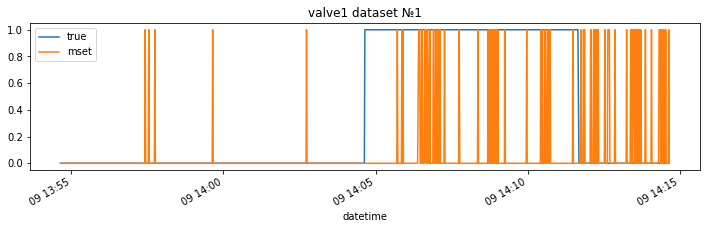

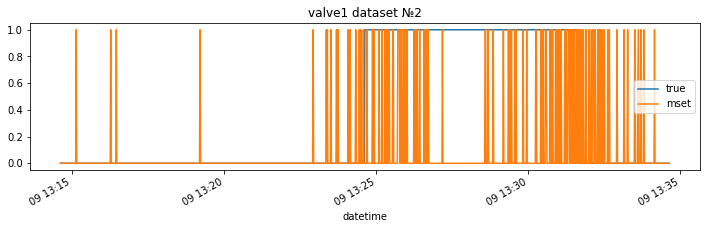

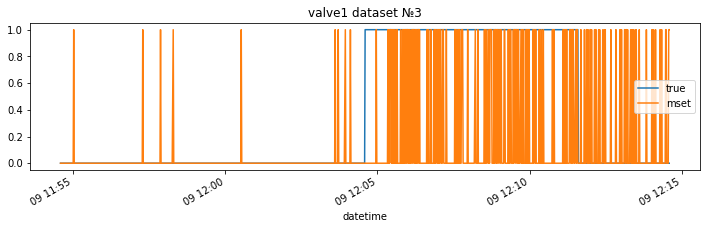

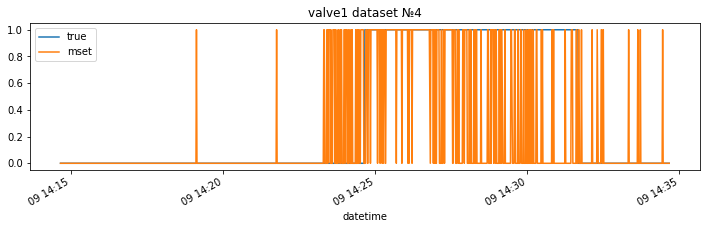

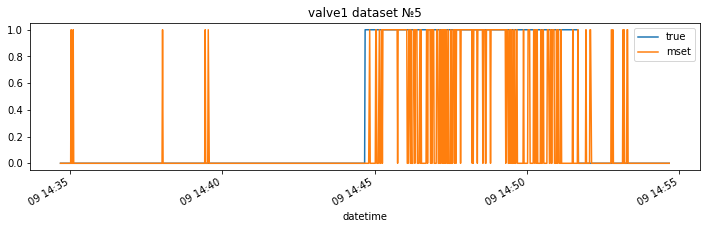

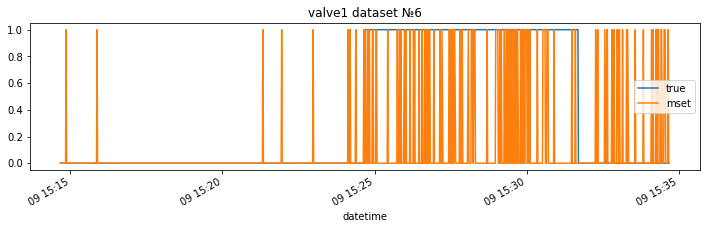

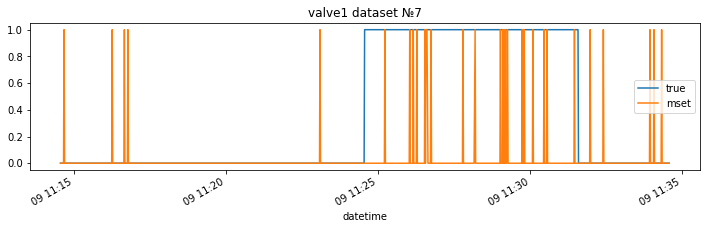

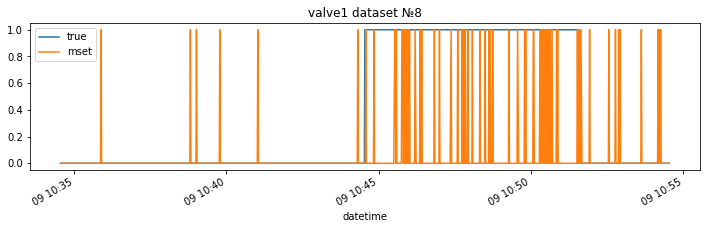

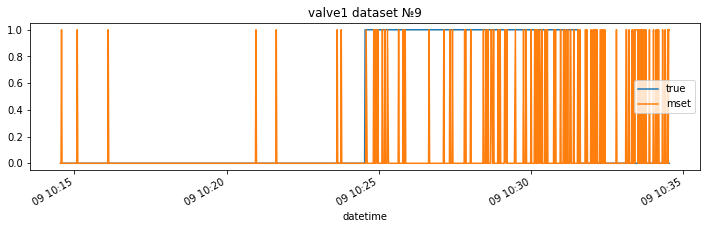

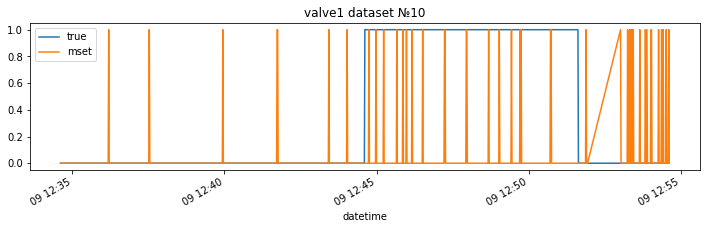

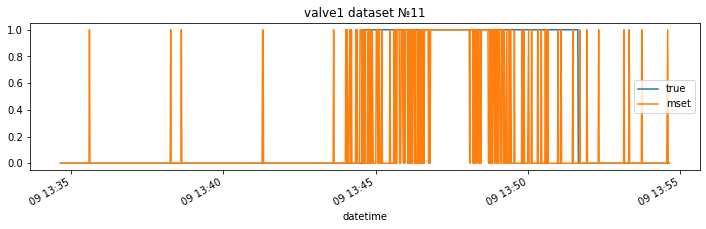

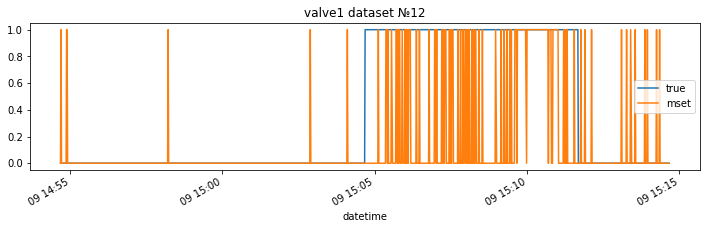

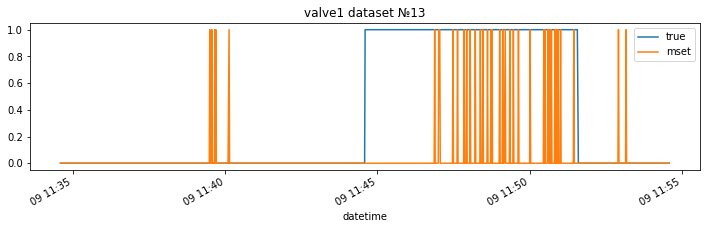

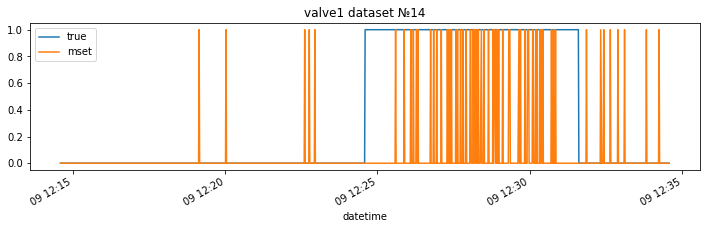

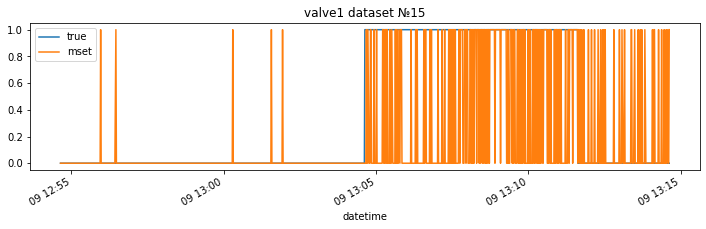

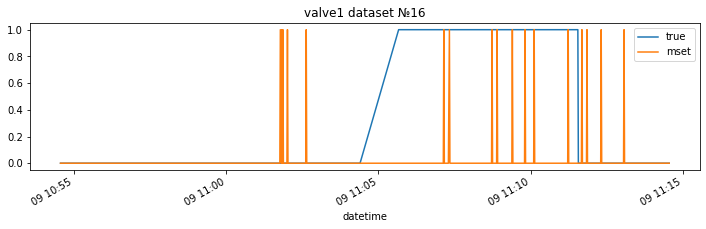

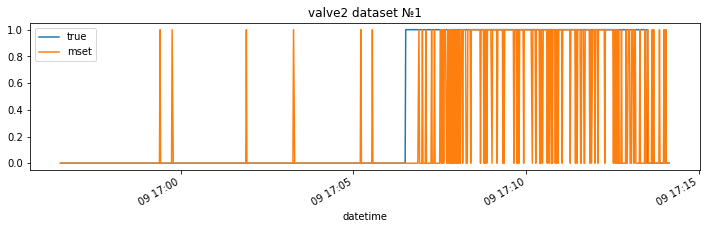

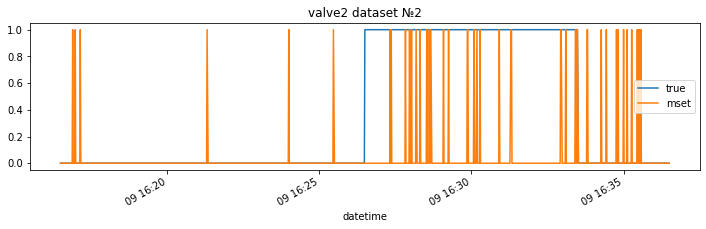

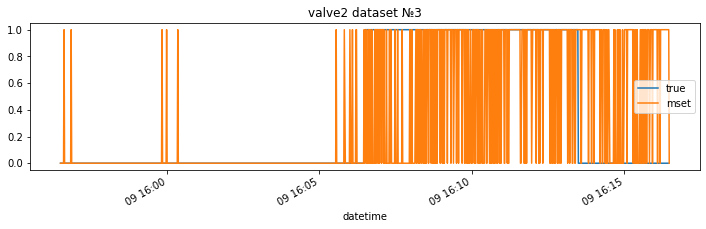

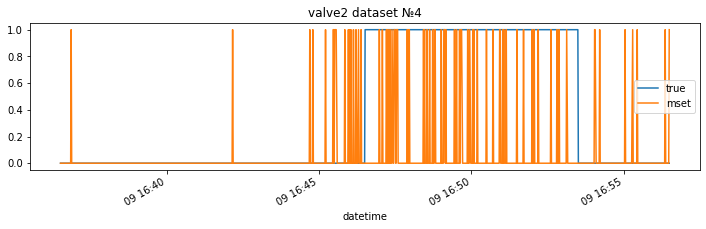

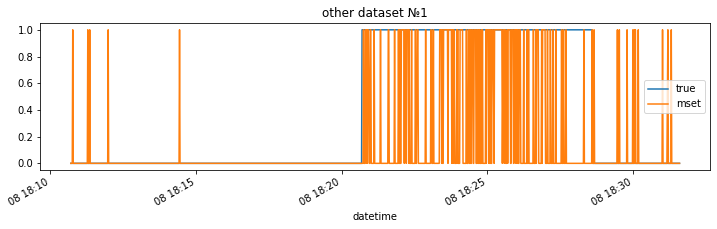

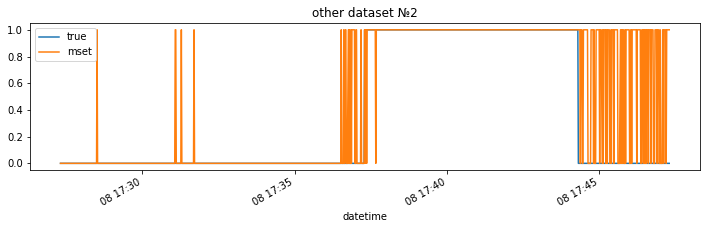

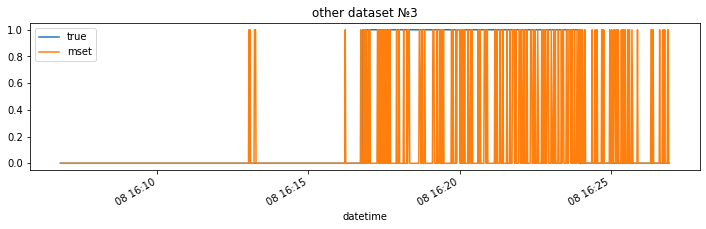

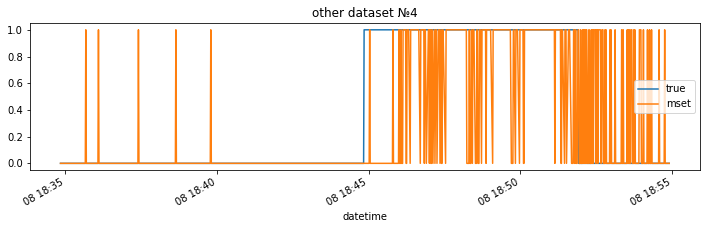

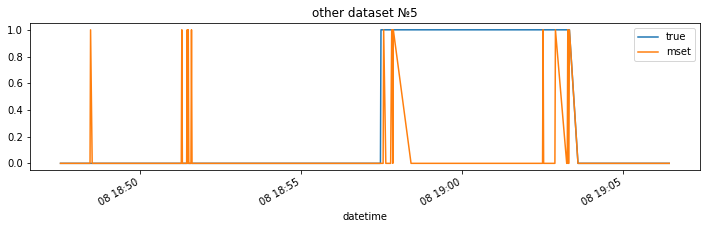

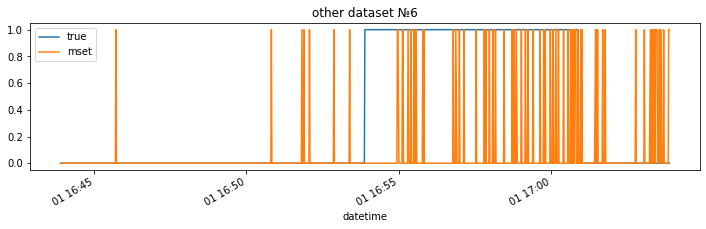

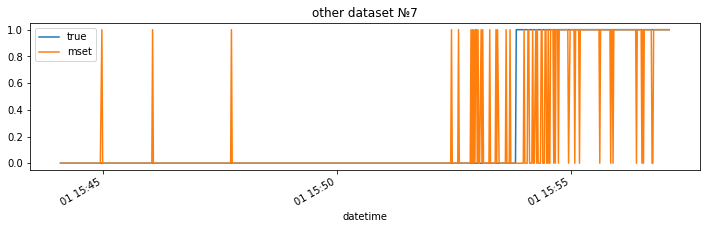

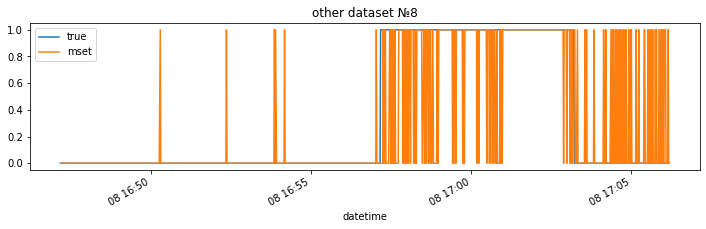

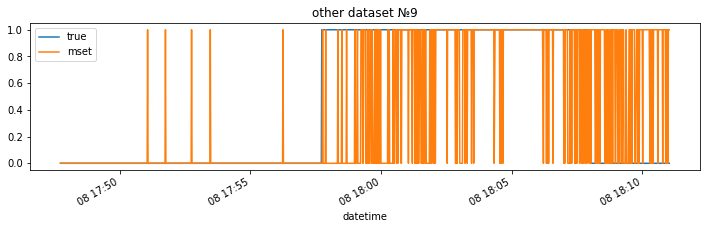

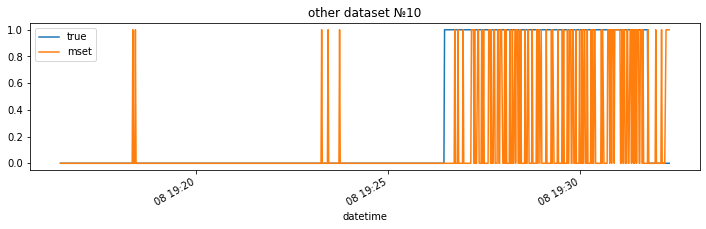

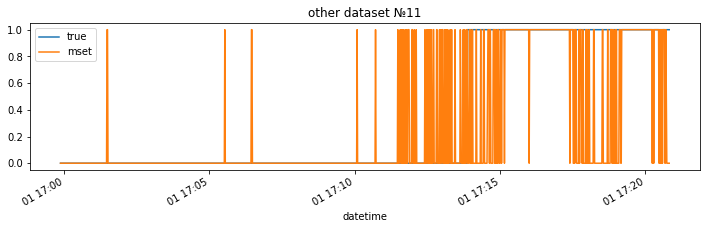

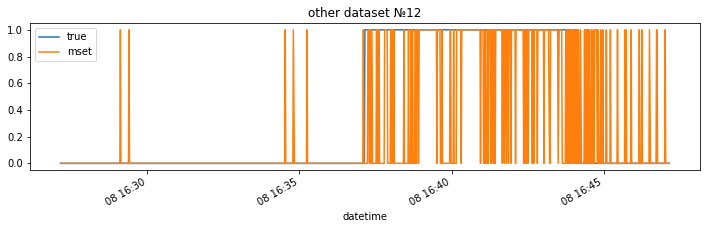

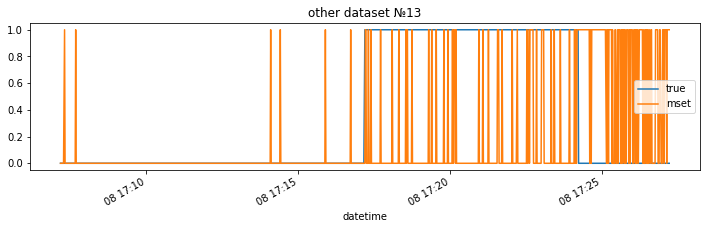

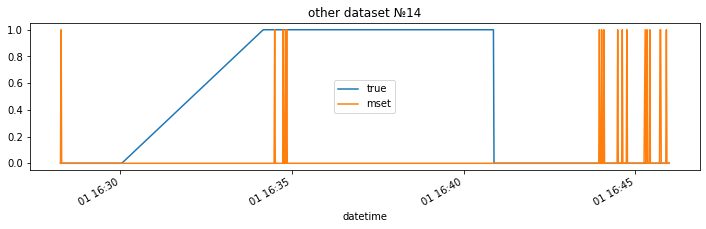

In [138]:
train_size = 500

anomalies = ["valve1", "valve2", "other"]

def make_prediction(df):
    df = df.drop(["anomaly", "changepoint"], axis=1)
    clf = IsolationForest(contamination=0.01, n_jobs=-1)
    clf.fit(df.values[:train_size])
    prediction_raw = clf.predict(df.values)
    prediction = pd.Series(prediction_raw, df.index).map({-1: 1, 1:0})
    return prediction

def print_score(list_of_df, predictions):
    true_outlier = pd.concat([df.anomaly for df in list_of_df])
    pred_outlier = pd.concat(predictions)
    print(f"F1 = {f1_score(true_outlier, pred_outlier)}\n" \
          f"FAR = {far(true_outlier, pred_outlier)}\n" \
          f"MAR = {mar(true_outlier, pred_outlier)})")

def show_plots(list_of_df, predictions):
    for i in range(len(predictions)): 
        plt.figure(figsize=(12,3))
        plt.title(f'{anomaly} dataset №{i+1}')  
        list_of_df[i].anomaly.plot(label='true')
        predictions[i].plot(label='mset')
        plt.legend()

        
for anomaly in anomalies:    

    list_of_df, _ = load_df("./data/", anomaly=anomaly)

    bar = IntProgress(
        min=0, max=len(list_of_df), 
        description=f"{anomaly}", style={'bar_color': '#61dc8a'},)

    display(bar)

    predictions = []
    for df in list_of_df:
        predictions.append(make_prediction(df))
        bar.value += 1

    print_score(list_of_df, predictions)
    show_plots(list_of_df, predictions)

## Vizualization

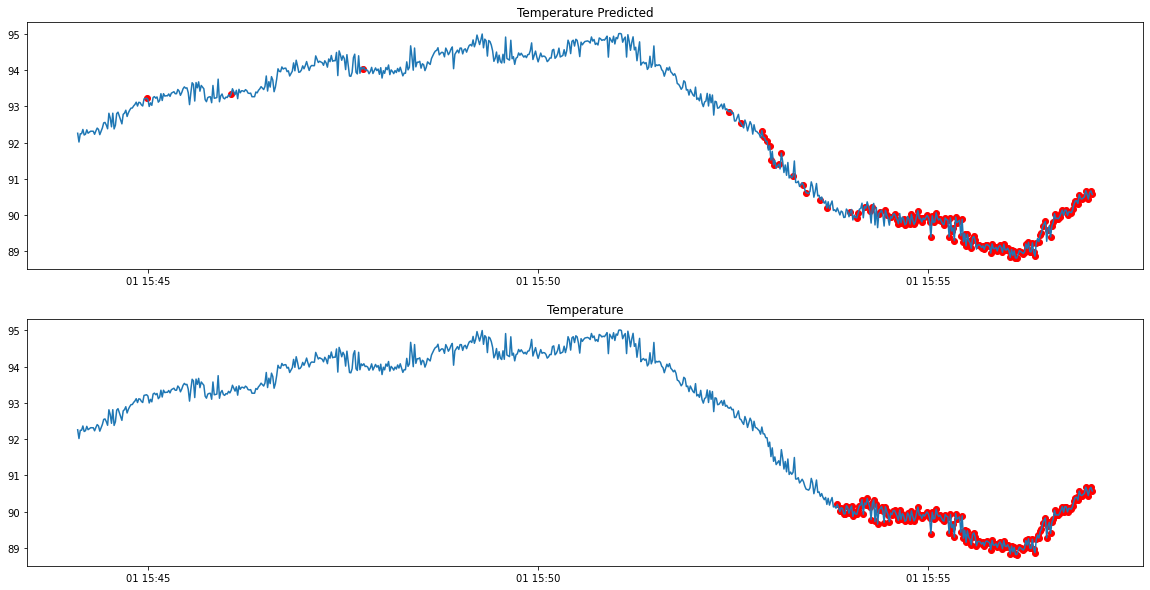

In [155]:
i = 6

fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = list_of_df[i].Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(predictions[i])
anomalies_indecies = y.index[y == 1]
axs[0].scatter(list_of_df[i].loc[anomalies_indecies].index, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(list_of_df[i].anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(list_of_df[i].index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

### Вывод

Если в выборке большая доля аномалий, лучше обучаться только на здоровых данных.

anomaly  | F1, % | FAR, % | MAR, %
--- | --- | --- | --- |
valve1 | 0.35 | 0.038 | 0.77
valve2 | 0.49 | 0.067 | 0.63
other | 0.57 | 0.074 | 0.55

В процессе обучения возникла идея: устроить голосование лесов, т.е. обучить несколько лесов на разных датасетах с одним типом аномалии, и используя некоторый порог определять аномалии. Либо обучить несколько лесов на одном и том же датасете и по аналогии проголосовать.

IntProgress(value=0, description='valve1', max=16, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.6851230824117017
FAR = 0.245126993502658
MAR = 0.2390236170550008)


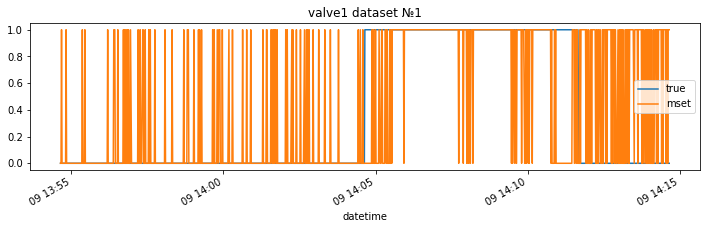

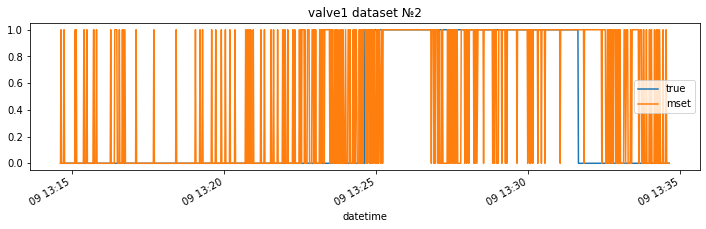

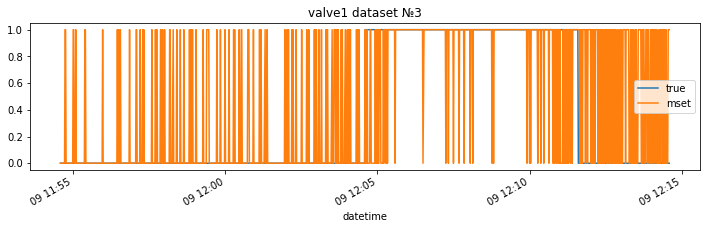

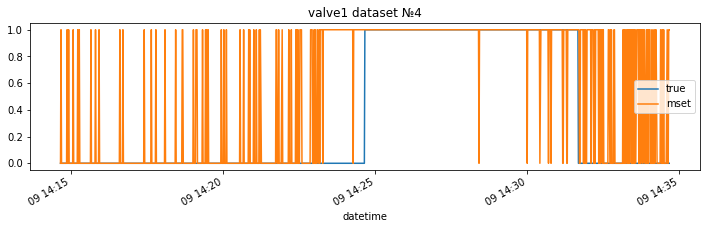

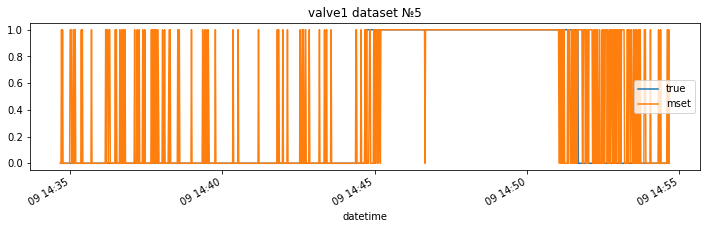

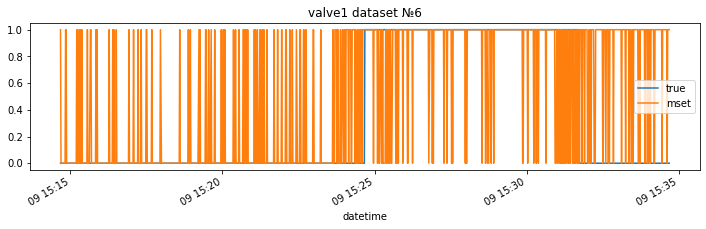

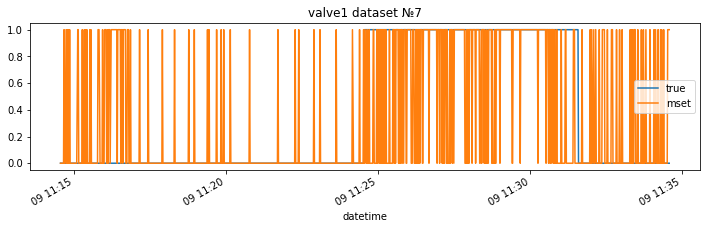

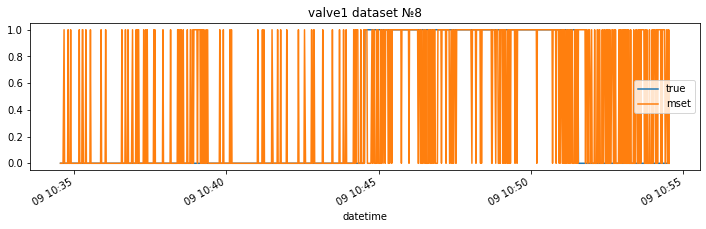

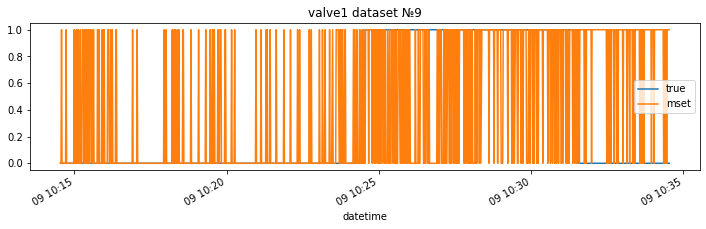

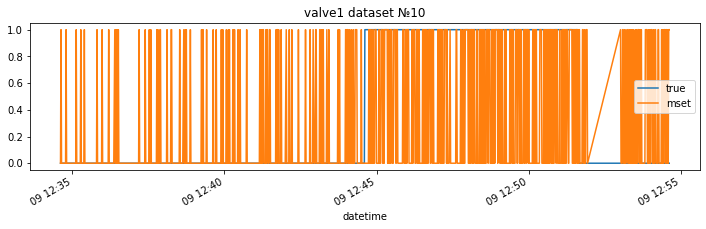

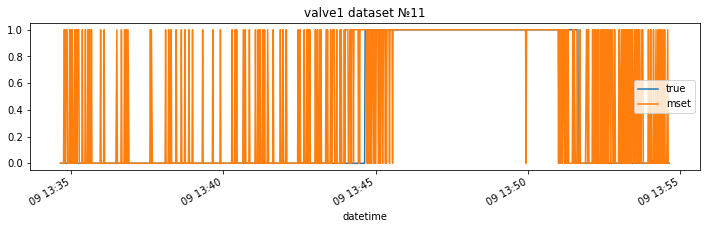

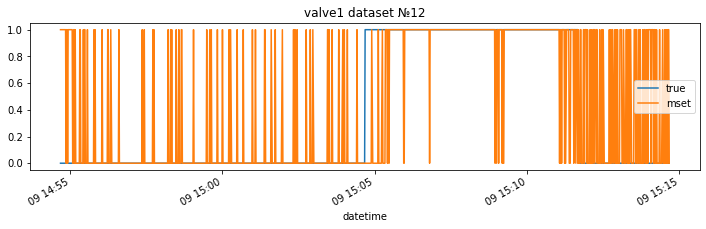

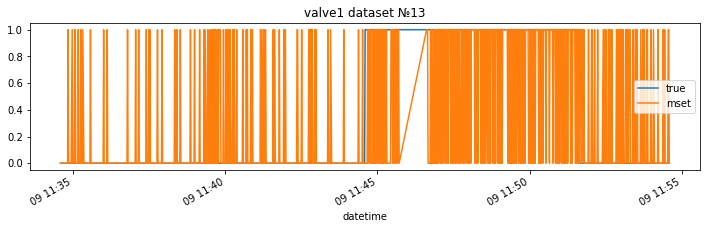

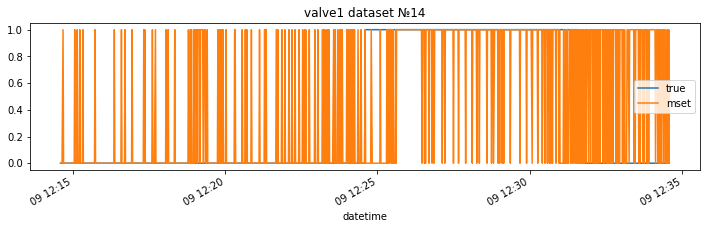

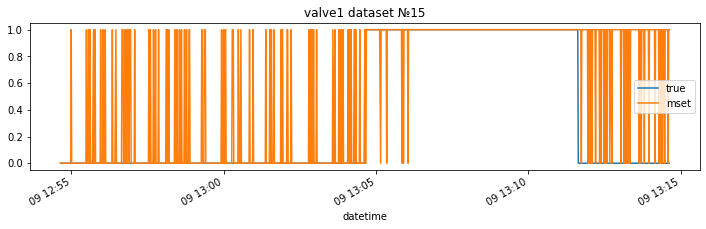

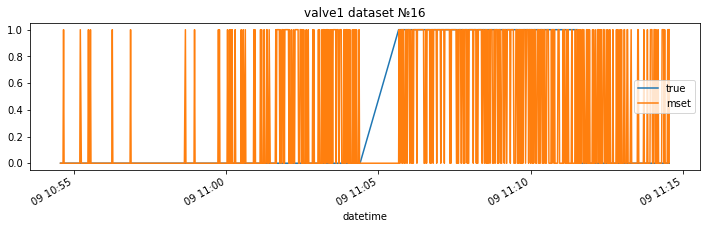

In [227]:
train_size = 500
vote_threshold = 0.5

# anomalies = ["valve1", "valve2", "other"]
anomalies = ["valve1"]

def make_prediction_1(df, list_of_df):
    # One tree learn on different datasets
    df = df.drop(["anomaly", "changepoint"], axis=1)
    predictions = []
    
    for df_train in list_of_df:
        df_train = df_train.drop(["anomaly", "changepoint"], axis=1)
        clf = IsolationForest(contamination=0.01, n_jobs=-1)
        clf.fit(df_train.values[:train_size])
        prediction_raw = clf.predict(df.values)
        prediction = pd.Series(prediction_raw, df.index).map({-1: 1, 1:0})
        predictions.append(prediction)
    
    return (pd.DataFrame(predictions).mean() > vote_threshold).astype(int)


def make_prediction_2(df, trees_count=20):
    # Several trees learn on same dataset
    df = df.drop(["anomaly", "changepoint"], axis=1)
    clfs = [IsolationForest(contamination=0.15, n_jobs=-1) for _ in range(trees_count)]
    
    predictions = []
    for clf in clfs:
        clf.fit(df.values[:train_size])
        prediction_raw = clf.predict(df.values)
        prediction = pd.Series(prediction_raw, df.index).map({-1: 1, 1:0})
        predictions.append(prediction)
           
    return (pd.DataFrame(predictions).mean() > vote_threshold).astype(int)


for anomaly in anomalies:    

    list_of_df, _ = load_df("./data/", anomaly=anomaly)

    bar = IntProgress(
        min=0, max=len(list_of_df), 
        description=f"{anomaly}", style={'bar_color': '#61dc8a'},)

    display(bar)

    predictions = []
    for df in list_of_df:
        # predictions.append(make_prediction_1(df, list_of_df))
        predictions.append(make_prediction_2(df))
        bar.value += 1

    print_score(list_of_df, predictions)
    show_plots(list_of_df, predictions)